In [1]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
print(tf.__version__)

2.18.0


### Data Loading

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mfrfathi","key":"3ca1100451ab2bf21a7b3735acf83d57"}'}

In [4]:
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 600)

In [5]:
!kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors


In [6]:
!unzip intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [7]:
source_train = "seg_train/seg_train"
source_val = "seg_test/seg_test"
combined_dir = "intel_dataset"

os.makedirs(combined_dir, exist_ok=True)

for source in [source_train, source_val]:
    for label in os.listdir(source):
        src_folder = os.path.join(source, label)
        dst_folder = os.path.join(combined_dir, label)
        os.makedirs(dst_folder, exist_ok=True)
        for file in os.listdir(src_folder):
            shutil.copy(os.path.join(src_folder, file), dst_folder)

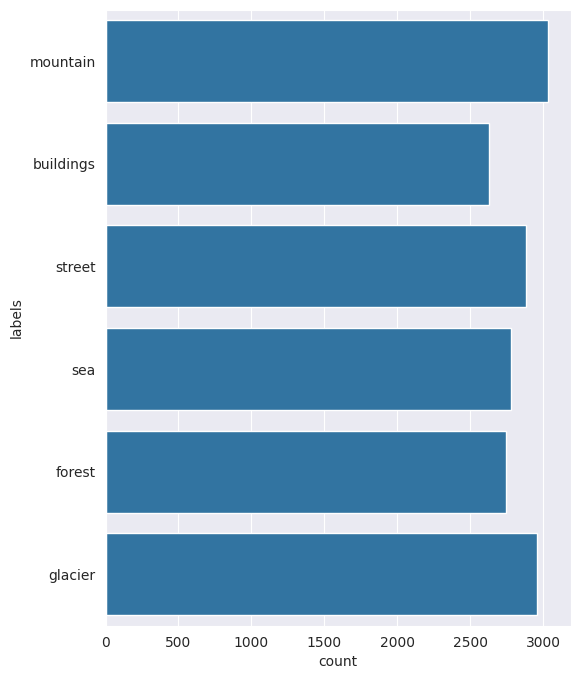

In [8]:
intel_path = "intel_dataset"

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(intel_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,8))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Data Splitting

In [9]:
!pip install split-folders
import splitfolders

splitfolders.ratio("intel_dataset", output="intel_split", seed=42, ratio=(.64, .16, .20))

Copying files: 17034 files [00:02, 8320.70 files/s]


In [10]:
def verify_image_sizes(folder_path, expected_size=(150, 150)):
    mismatch = []
    for path in Path(folder_path).rglob("*.*"):
        if path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
            with Image.open(path) as img:
                if img.size != expected_size:
                    mismatch.append((path, img.size))
    print(f"Total: {len(list(Path(folder_path).rglob('*.jpg')))} gambar")
    print(f"Yang tidak {expected_size}: {len(mismatch)}")

verify_image_sizes("intel_dataset", expected_size=(150, 150))

Total: 17034 gambar
Yang tidak (150, 150): 55


### Preprocessing

In [15]:
# Ukuran gambar target dan batch size
IMG_SIZE = (128, 128)
BATCH_SIZE = 64

def load_dataset(dir_path):
    return tf.keras.preprocessing.image_dataset_from_directory(
        dir_path,
        labels='inferred',
        label_mode='categorical',
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        interpolation='nearest'
    )

# Load dataset
train_ds = load_dataset('intel_split/train')
val_ds = load_dataset('intel_split/val')
test_ds = load_dataset('intel_split/test')

CLASS = train_ds.class_names
print(f"Class: {CLASS}")

Found 10898 files belonging to 6 classes.
Found 2723 files belonging to 6 classes.
Found 3413 files belonging to 6 classes.
Class: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


### Modeling

In [16]:
model = Sequential([
    Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(128, (4,4), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(256, (7,7), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Tampilkan ringkasan arsitektur
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 256)    │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,883,782 (14.82 MB)

 Trainable params: 3,882,758 (14.81 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [17]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 25s 109ms/step - accuracy: 0.3475 - loss: 2.4513 - val_accuracy: 0.4862 - val_loss: 1.3914 - learning_rate: 0.0010
Epoch 2/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 33s 85ms/step - accuracy: 0.4403 - loss: 1.4624 - val_accuracy: 0.4117 - val_loss: 1.7196 - learning_rate: 0.0010
Epoch 3/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.4989 - loss: 1.2580 - val_accuracy: 0.5747 - val_loss: 1.0890 - learning_rate: 0.0010
Epoch 4/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - accuracy: 0.5635 - loss: 1.1154 - val_accuracy: 0.4620 - val_loss: 1.5825 - learning_rate: 0.0010
Epoch 5/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - accuracy: 0.6129 - loss: 1.0016 - val_accuracy: 0.5729 - val_loss: 1.3575 - learning_rate: 0.0010
Epoch 6/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.6463 - loss: 0.9278 - val_accuracy: 0.6750 - val_loss: 0.9737 - learning_rate: 0.0010
Epoch 7/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.

In [18]:
train_loss, train_acc = model.evaluate(train_ds, verbose=0)
print(f"✅ Training Accuracy: {train_acc*100:.2f}%")

# Evaluasi akurasi di Test Set
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")

✅ Training Accuracy: 95.53%
✅ Test Accuracy: 88.13%


### Plot Akurasi dan Loss

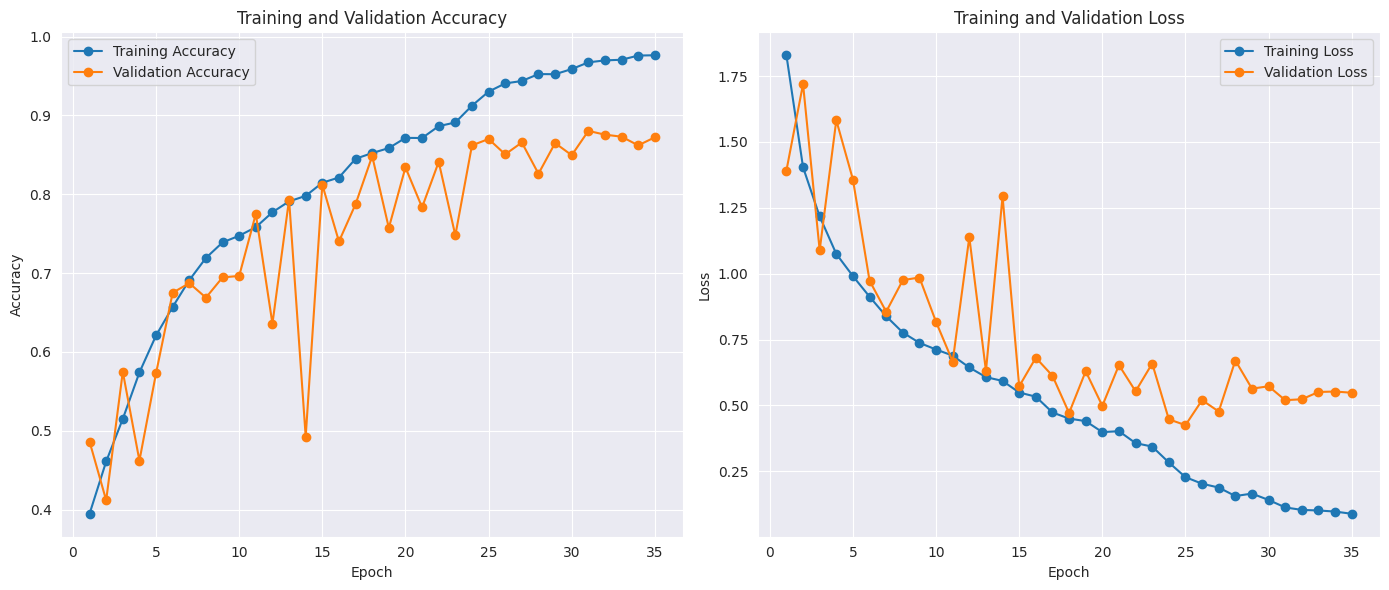

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)


plt.figure(figsize=(14,6))

# Plot Akurasi
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Menyimpan Model

#### SavedModel

In [22]:
save_path = 'model_savedmodel/'
tf.saved_model.save(model, save_path)

#### TF-Lite

In [30]:
converter = tf.lite.TFLiteConverter.from_saved_model("model_savedmodel/")
tflite_model = converter.convert()

tflite_model_path = "model_tflite.tflite"
with tf.io.gfile.GFile(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

label_file_path = "labels.txt"
with open(label_file_path, "w") as f:
    for label in CLASS:
        f.write(label + "\n")

#### TFJS

In [27]:
!pip install tensorflowjs

import tensorflowjs as tfjs

tfjs_target_dir = "model_tfjs"
tfjs.converters.save_keras_model(model, tfjs_target_dir)

failed to lookup keras version from the file,
    this is likely a weight only file
